<a href="https://colab.research.google.com/github/jiwonlydia/ReturnPrediction/blob/main/0525_ffn%2Blstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
path = '/content/drive/MyDrive/송교수님 weekly meeting/return_prediction/Empirical Asset Pricing Via Machine Learning/char60_1996_2021'
os.chdir(path)

In [6]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 82 kB/s 


In [7]:
import pandas as pd
import numpy as np
import datetime as dt
import pyarrow.feather as feather
# import wrds
# from functions import *
from pandas.tseries.offsets import *
from refit_model import *
from preprocess import *
import matplotlib.pyplot as plt
import seaborn as sns
import random

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM
from tensorflow.keras.models import Model

from sklearn.preprocessing import MinMaxScaler
## display
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_seq_items', None)

In [8]:
raw1990 = pd.read_csv('chars60_raw_1990s.csv')
raw2000 = pd.read_csv('chars60_raw_2000s.csv')
raw2010 = pd.read_csv('chars60_raw_2010s.csv')
raw2020 = pd.read_csv('chars60_raw_2020s.csv')

raw = pd.concat([raw1990,raw2000,raw2010,raw2020], axis=0)

raw['date'] = pd.to_datetime(raw['date'])
raw['month'] = raw['date'].dt.month

In [9]:
macro = pd.read_csv('2_Macroeconomic Variables.csv')
macro['date'] = pd.to_datetime(macro['date'])
macro['year'] = macro['date'].dt.year
macro['month'] = macro['date'].dt.month
# macro = macro[macro['date'] >= '1995-08-01'] # x_frames=5 기준

# train test split
train_set = macro[macro['date'].dt.year < 2017]
test_set = macro[macro['date'].dt.year >= 2017]

# scaling
macro_features = macro.columns.drop(['date','year','month'])
my_scaler(scaling_features=macro_features, fit_data=train_set, transform_data=test_set)

macro_X_train = train_set
macro_X_test = test_set
# x_frames = 5 ; y_frames = 1
# macro_trainX, macro_trainY = build_timeseries(train_set, macro_features, x_frames, y_frames)
# macro_testX, macro_testY = build_timeseries(test_set, macro_features, x_frames, y_frames)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [10]:
df500 = AnnualCap(raw_data=raw, start_year=1996, end_year=2020)

In [11]:
df500_macro = pd.merge(df500, macro.drop(['date'],axis=1), on=['year','month'], how='left')
# df500_macro.columns

In [12]:
macro_features = macro.columns.drop(['date','year','month'])
macro_features = macro_features.tolist()

In [31]:
len(macro_features)

125

In [33]:
df = df500_macro.copy()
firm_features = df.columns.drop(['date','gvkey','permno','sic','ret','ticker','month']).tolist()
features = firm_features + macro_features
# features = ['adm', 'bm_ia', 'herf', 'hire', 'me_ia', 'ill', 
#                     'maxret', 'mom12m', 'mom1m', 'mom36m', 'mom60m', 'mom6m', 'std_dolvol',
#                     'me', 'dy', 'nincr','pscore', 'acc', 'bm', 'agr', 'alm', 'ato', 'cash', 'cashdebt',
#                      'cfp', 'chcsho','chtx','b/m', 'tbl', 'lty', 'ntis','svar'] + macro_features

print(features)

['exchcd', 'shrcd', 'adm', 'bm_ia', 'herf', 'hire', 'me_ia', 'ill', 'maxret', 'mom12m', 'mom1m', 'mom36m', 'mom60m', 'mom6m', 'std_dolvol', 'me', 'dy', 'cinvest', 'nincr', 'pscore', 'acc', 'bm', 'agr', 'alm', 'ato', 'cash', 'cashdebt', 'cfp', 'chcsho', 'chpm', 'chtx', 'depr', 'ep', 'gma', 'grltnoa', 'lev', 'lgr', 'ni', 'noa', 'op', 'pctacc', 'pm', 'rd_sale', 'rdm', 'rna', 'roa', 'roe', 'rsup', 'sgr', 'sp', 'ffi49', 'year', 'RPI', 'W875RX1', 'DPCERA3M086SBEA', 'INDPRO', 'IPFPNSS', 'IPFINAL', 'IPCONGD', 'IPDCONGD', 'IPNCONGD', 'IPBUSEQ', 'IPMAT', 'IPDMAT', 'IPNMAT', 'IPMANSICS', 'IPB51222S', 'IPFUELS', 'CUMFNS', 'CLF16OV', 'CE16OV', 'UNRATE', 'UEMPMEAN', 'UEMPLT5', 'UEMP5TO14', 'UEMP15OV', 'UEMP15T26', 'UEMP27OV', 'PAYEMS', 'USGOOD', 'CES1021000001', 'USCONS', 'MANEMP', 'DMANEMP', 'NDMANEMP', 'SRVPRD', 'USTPU', 'USWTRADE', 'USTRADE', 'USFIRE', 'USGOVT', 'CES0600000007', 'AWOTMAN', 'AWHMAN', 'HOUST', 'HOUSTNE', 'HOUSTMW', 'HOUSTS', 'HOUSTW', 'PERMIT', 'PERMITNE', 'PERMITMW', 'PERMITS', 'P

In [34]:
train_set = df[df['year']<2017]
test_set = df[df['year']>=2017]
X_train, y_train = train_set[features], np.array(train_set['ret'])
X_test, y_test = test_set[features], np.array(test_set['ret'])

In [35]:
# scaling_features = X_train.columns.drop(['year','ffi49'])
# 'cinvest', 'chpm', 'depr', 'ep', 'gma', 'grltnoa', 'lev', 'lgr','ni', 'noa', 'op'

my_scaler(scaling_features=features, fit_data=X_train, transform_data=X_test)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: ignored

In [24]:
ffn_input = Input(shape=(X_train.shape[1],))
ffn_hidden1 = Dense(128, activation='relu')(ffn_input)
# batchnorm1 = tf.keras.layers.BatchNormalization()(ffn_hidden1)
ffn_hidden2 = Dense(64, activation='relu')(ffn_hidden1)
# batchnorm2 = tf.keras.layers.BatchNormalization()(ffn_hidden2)
ffn_hidden3 = Dense(64, activation='relu')(ffn_hidden2)
ffn_hidden4 = Dense(32, activation='relu')(ffn_hidden3)
ffn_output = Dense(1)(ffn_hidden4)

ffn_model = Model(inputs=ffn_input, outputs=ffn_output)
ffn_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 157)]             0         
                                                                 
 dense_4 (Dense)             (None, 128)               20224     
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 34,753
Trainable params: 34,753
Non-trainable

In [25]:
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
ffn_model.compile(optimizer=opt, loss='mse', metrics=['mse'])
# inputs=[lstm_input, ffn_input], outputs=ffn_output)
ffn_model.fit(X_train, y_train,
              epochs=100, batch_size=10000, shuffle=False)

Epoch 1/100
12/12 [==============================] - 1s 48ms/step - loss: 0.3968 - mse: 0.3968
Epoch 2/100
12/12 [==============================] - 1s 48ms/step - loss: 0.0545 - mse: 0.0545
Epoch 3/100
12/12 [==============================] - 1s 46ms/step - loss: 0.0144 - mse: 0.0144
Epoch 4/100
12/12 [==============================] - 1s 47ms/step - loss: 0.0142 - mse: 0.0142
Epoch 5/100
12/12 [==============================] - 1s 45ms/step - loss: 0.0144 - mse: 0.0144
Epoch 6/100
12/12 [==============================] - 1s 50ms/step - loss: 0.0131 - mse: 0.0131
Epoch 7/100
12/12 [==============================] - 1s 88ms/step - loss: 0.0129 - mse: 0.0129
Epoch 8/100
12/12 [==============================] - 1s 100ms/step - loss: 0.0134 - mse: 0.0134
Epoch 9/100
12/12 [==============================] - 1s 98ms/step - loss: 0.0128 - mse: 0.0128
Epoch 10/100
12/12 [==============================] - 1s 87ms/step - loss: 0.0147 - mse: 0.0147
Epoch 11/100
12/12 [============================

In [26]:
y_pred = ffn_model.predict(X_test)
y_pred = y_pred.reshape(-1)

In [27]:
r2_oos(y_test, y_pred.reshape(-1))

0.18068079599866016

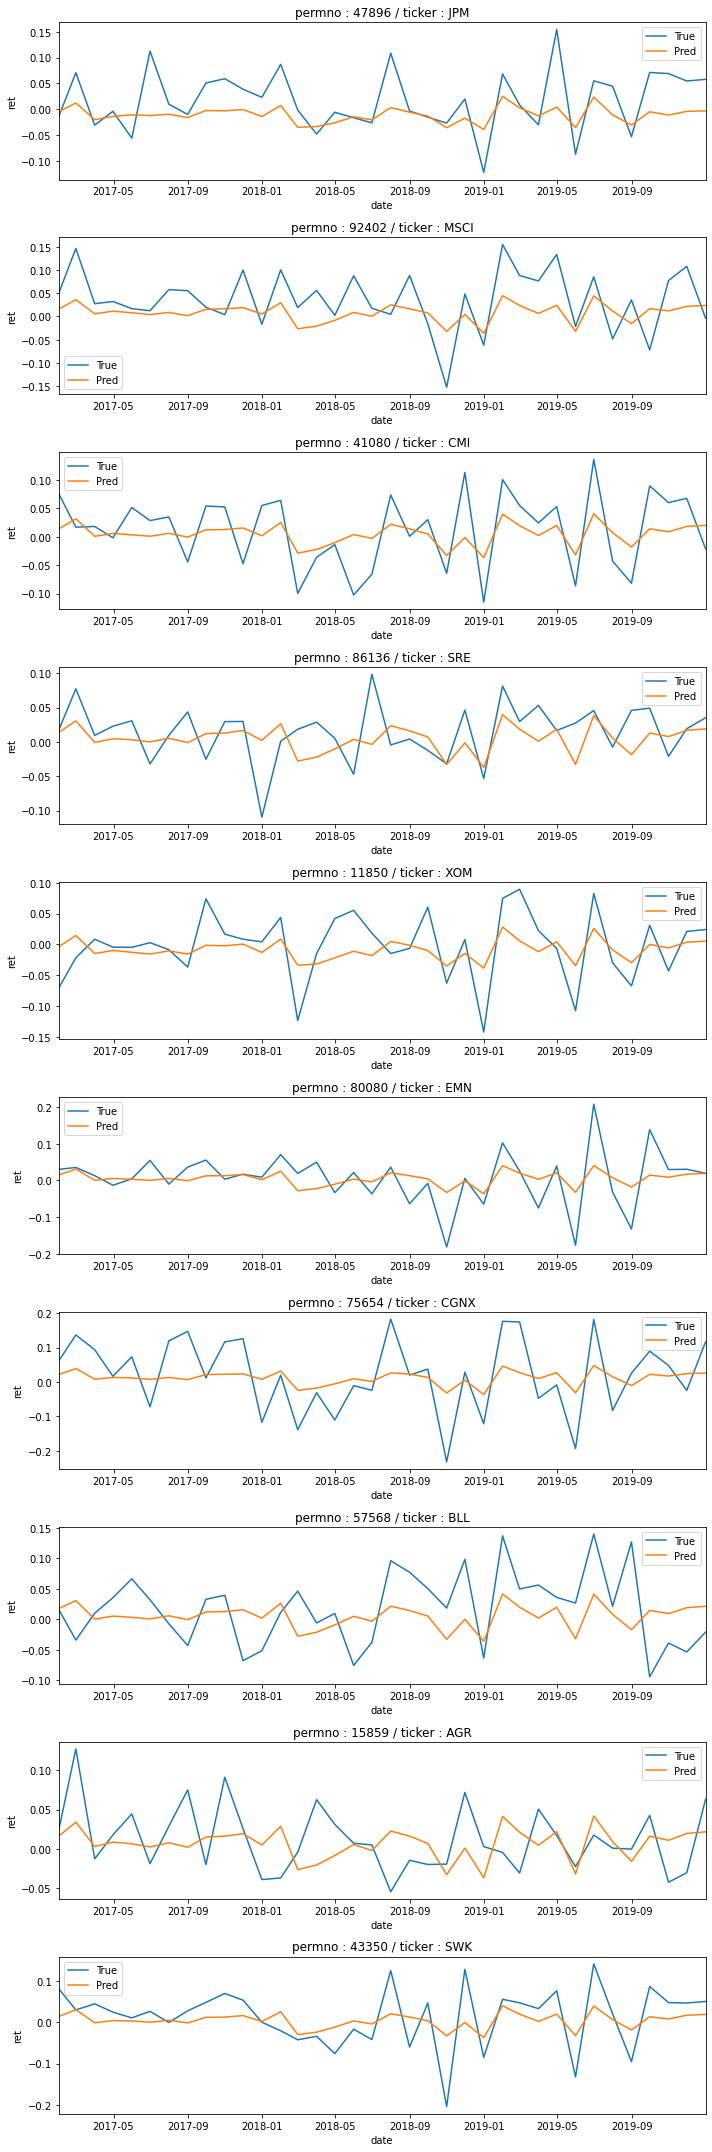

In [29]:
plot_predictions(test_set, y_pred, num_samples=10, seed=4)

In [120]:
# lstm_input = Input(shape=(macro_trainX.shape[1], macro_trainX.shape[2]), name='Macro Input') # shape = (timesteps, columns_size)
# lstm_out = LSTM(4, )(lstm_input) # macro output
# lstm_model = Model(inputs=lstm_input, outputs=lstm_out)

# ffn_input = Input(shape=(X_train.shape[1],), name='FirmChar Input')

# x = tf.keras.layers.concatenate([lstm_model.output, ffn_input])

# ffn_hidden1 = Dense(128, activation='relu', kernel_initializer='uniform')(x)
# ffn_hidden2 = Dense(64, activation='relu')(ffn_hidden1)
# ffn_hidden3 = Dense(64, activation='relu')(ffn_hidden2)
# ffn_output = Dense(1)(ffn_hidden3)

# ffn_model = Model(inputs=[lstm_input, ffn_input], outputs=ffn_output)
# ffn_model.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Macro Input (InputLayer)       [(None, 5, 125)]     0           []                               
                                                                                                  
 lstm_5 (LSTM)                  (None, 4)            2080        ['Macro Input[0][0]']            
                                                                                                  
 FirmChar Input (InputLayer)    [(None, 32)]         0           []                               
                                                                                                  
 concatenate_5 (Concatenate)    (None, 36)           0           ['lstm_5[0][0]',                 
                                                                  'FirmChar Input[0][0]']  

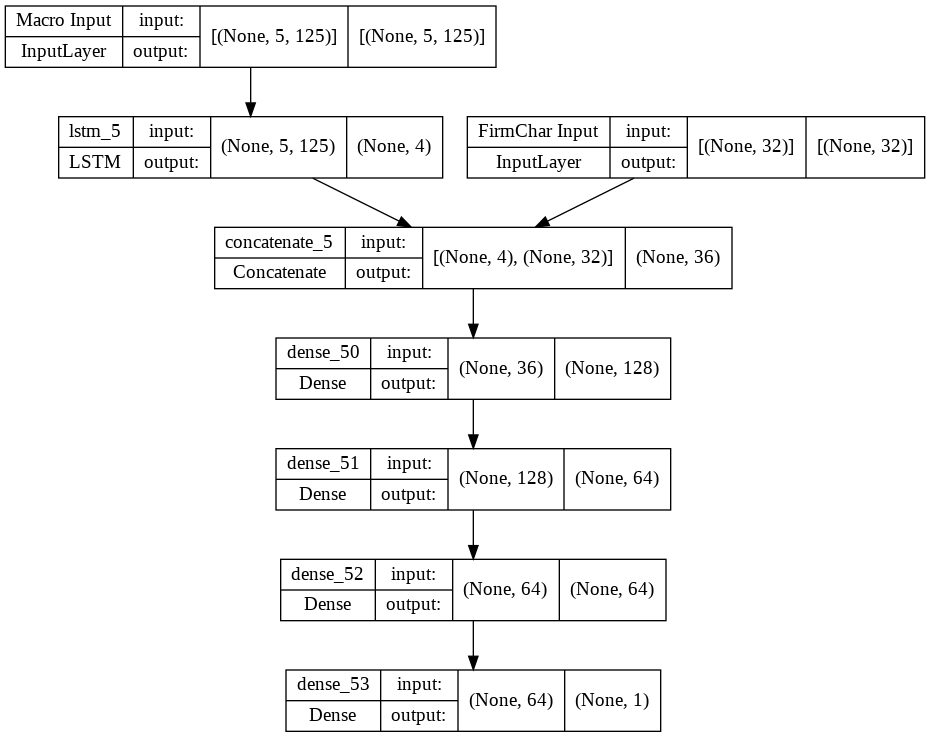

In [123]:
tf.keras.utils.plot_model(ffn_model, 'my_first_model.png', show_shapes=True)

In [159]:
# opt = tf.keras.optimizers.Adam(learning_rate=0.01)
# ffn_model.compile(optimizer=opt, loss='mse', metrics=['mse'])
# # inputs=[lstm_input, ffn_input], outputs=ffn_output)
# ffn_model.fit([macro_trainX, X_train], y_train,
#               epochs=30, batch_size=10000, shuffle=False)

In [96]:
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1)

In [97]:
y_pred

array([0.03547873, 0.03269179, 0.03186164, ..., 0.01584164, 0.01678121,
       0.0177186 ], dtype=float32)

In [98]:
y_test

array([ 0.07484635,  0.04758011,  0.03317738, ...,  0.028044  ,
       -0.05784867,  0.09815806])

In [21]:
def plot_predictions(test_set, y_pred, num_samples, seed=None):
    import random
    random.seed(seed)
    
    data = test_set.copy()
    data['y_pred'] = y_pred
    data['date'] = pd.to_datetime(data['date'])
    unq_list = random.sample(data['permno'].unique().tolist(), num_samples)
    
    f, ax = plt.subplots(nrows=num_samples, ncols=1, figsize=(10, num_samples*3))    
    for i, p in enumerate(unq_list):
        temp = data[data['permno']==p]
        tic = temp['ticker'].values[0]
        g = sns.lineplot(data=temp, x='date', y='ret', ci=None, ax=ax[i],
                        label='True')
        g = sns.lineplot(data=temp, x='date', y='y_pred', ci=None, ax=ax[i],
                        label='Pred')
        g.set_title(f'permno : {p} / ticker : {tic}')
#         g.set_ylim(-.1, .1)
        g.set_xlim(data['date'].min(), data['date'].max())
        plt.tight_layout()


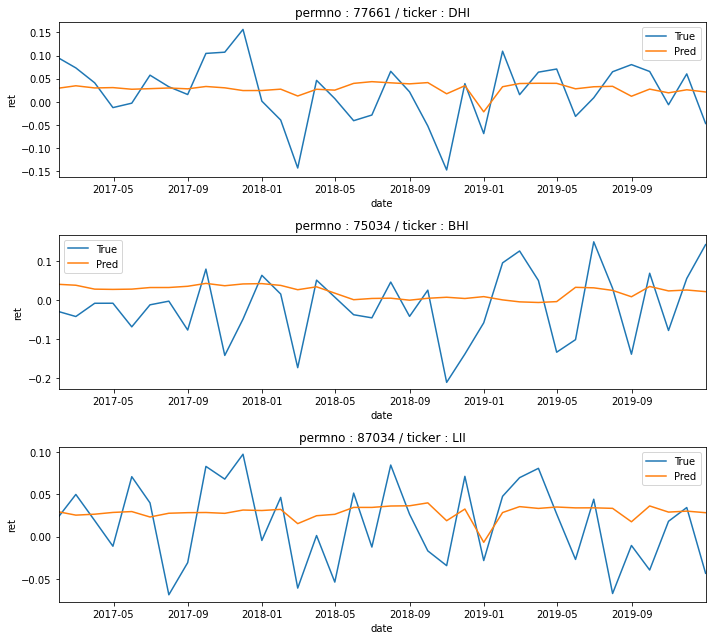

In [100]:
plot_predictions(test_set, y_pred, num_samples=3, seed=1)

In [22]:
def r2_oos(true, pred):
    if sum(true**2) == 0:
        result = 'zero division error'
    else:
        result = 1 - sum((true - pred)**2) / sum(true**2)
    return result

In [164]:
r2_oos(y_test, y_pred.reshape(-1))

0.20734015246150772

In [ ]:
sd